# PAML for dynamic systems:
### Energy-conserving continuous-time models
Example system: Two mass oscillator

---

Lecture: "Physics-augmented machine learning" @ Cyber-Physical Simulation, TU Darmstadt

Lecturer: Prof. Oliver Weeger

Author: Fabian J. Roth

---

#### In this notebook, you will...

* <span style="color:red">learn something... Todo.</span>

In [1]:
def is_colab():
    """Determine if the code is running in Google Colab."""
    try:
        import google.colab

        return True
    except ImportError:
        return False


if is_colab():
    print("Running in Google Colab, trying to install LecturePhysicsAwareML...")
    !git clone --depth 1 https://github.com/Drenderer/LecturePhysicsAwareML.git
    %cd LecturePhysicsAwareML/dynamic_modeling
    %pip install -e .
    print(
        "Make sure to restert the session after installation (Runtime > Restart Session)."
    )
else:
    print(
        "Not running in Google Colab. \nPlease install the package manually if needed. If you are using pip, run:\n>>> pip install -e .\nin the dynamic_modeling directory."
    )

Not running in Google Colab. 
Please install the package manually if needed. If you are using pip, run:
>>> pip install -e .
in the dynamic_modeling directory.


In [2]:
from dynamic_modeling import (
    ODESolver
)
from dynamic_modeling.two_mass_oscillator import (
    TwoMassOscillator,
    plot_trajectory,
    plot_energy,
    set_minimum_axis_limits,
)
import klax

import jax
import jax.random as jr
import jax.numpy as jnp
import equinox as eqx
import optax

from jaxtyping import PRNGKeyArray, Array

import matplotlib.pyplot as plt

# Use jax in float 64 mode (not strictly necessary)
jax.config.update('jax_enable_x64', True)

# Define global keyword arguments for plotting
true_kwargs = dict(color="black", lw=2, marker='o', markevery=20)

# Set the seeds for the random number generator
key = jr.key(0)
mlp_key, loader_key = jr.split(key)

## 1. The two mass oscillator
In this task we consider a simple linear two mass oscillator system:

<span style="color:red">Image</span>
<!-- <img src="images\Spring_pendulum_only_cartesian.png" height="400"/> -->

Describing position of the masses $m_1$ and $m_2$ with generalized coordinates $q_1, q_2$ and their velocities $\dot q_1, \dot q_2$, the total kinetic energy $T$ and potential energy $U$ are given by
$$
\begin{align}
    T = \frac{1}{2}m_1 \dot q_1^2 + \frac{1}{2}m_2 \dot q_2^2, && U = \frac{1}{2}k_1q_1^2 + \frac{1}{2}k_2(q_2 - q_1)^2.
\end{align}
$$

with spring constants $k_1$ and $k_2$.

In the last exercise we used the Euler-Lagrange equation to obtain the equations of motion. So naturally, this time we'll use the Hamiltonian framework. This requires us to use the generalized momenta $p_i = m_i \dot q_i$ instead of the velocities $v_i=\dot q_i$. 
By substituting $q_i = \frac{p_i}{m_i}$ we can formulate the Hamiltonian $\mathcal{H}$ as the total energy:
$$
\begin{align}
    \mathcal{H}(q_1, q_2, p_1, p_2) = T + U = \frac{1}{2m_1}p_1^2 + \frac{1}{2m_2}p_2^2 + \frac{1}{2}k_1q_1^2 + \frac{1}{2}k_2(q_2 - q_1)^2 + C
\end{align}
$$
where $C$ is an arbitrary constant corresponding to the chosen zero-level of the potential energy.

Now we use Hamiltons equations of motion
$$
\begin{align}
    \frac{\partial q_i}{\partial t} &= \phantom{-}\frac{\partial \mathcal{H}}{\partial p_i}\\
    \frac{\partial p_i}{\partial t} &= -\frac{\partial \mathcal{H}}{\partial q_i}
\end{align}
$$
and plug in our $\mathcal{H}$. Then we get:

$$
\begin{align}
\dot q_1 &= \frac{p_1}{m_1}\\
\dot q_2 &= \frac{p_2}{m_2}\\
\dot p_1 &= -(k_1 + k_2)q_1 + k_2q_2\\
\dot p_2 &= k_2q_1 - k_2q_2
\end{align}
$$
Note that this is already a first order ODE. We will rewrite it in terms of velocities $v_1 = \frac{p_1}{m_1}, v_y = \frac{p_2}{m_2}$:
$$
\begin{align}
\dot q_1 &= v_x\\
\dot q_2 &= v_y\\
\dot v_1 &= -\frac{k_1 + k_2}{m_1}q_1 + \frac{k_2}{m_1}q_1\\
\dot v_2 &= \frac{k_2}{m_2}q_1 - \frac{k_2}{m_2}q_2
\end{align}
$$

Let's generate some trajectories, using varying initial positions.

## 1.1 Data generation
The following code cells generate and visualize data from the spring pendulum system.

Feel free to change the parameters marked by ``# <<<`` *later* during the tasks.

In [3]:
two_mass_oscillator = TwoMassOscillator(m1=1.0, m2=1.0, k1=1.0, k2=0.5)
true_system = ODESolver(two_mass_oscillator)

n = 20      # <<< Number of trajectories
t_max = 10  # <<< Length of trajectories [s]

key = jr.key(0)
r_key, θ_key = jr.split(key)
ts = jnp.linspace(0, t_max, 500)

# Generate random initial conditions for training
q0s = jr.uniform(r_key, (n, 2), minval=-1.0, maxval=1.0)
q_t0s = jnp.zeros_like(q0s)
y0s = jnp.concat([q0s, q_t0s], axis=-1)
ys = jax.vmap(true_system, in_axes=(None, 0))(ts, y0s)

# Make derivative data
ys_flat = jnp.reshape(ys, (-1, ys.shape[-1]))
ys_t_flat = jax.vmap(two_mass_oscillator, (None, 0))(None, ys_flat)

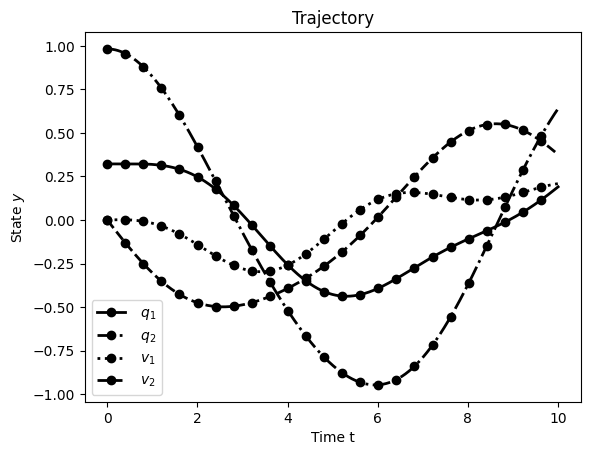

In [4]:
plot_trajectory(ts, ys[1], states="all", **true_kwargs) # type:ignore
plt.show()

Here we define the loss function. We will be using only derivative fitting for this task, which allows us to train the models faster than with trajectory fitting.

In [5]:
def derivative_loss(model: ODESolver, data, batch_axis):
    """Evaluate the models derivative function and compare it to the true derivative."""
    ys, ys_t = data
    ys_t_pred = jax.vmap(model.func, in_axes=0)(None, ys)
    return jnp.mean(jnp.square(ys_t_pred - ys_t))

## 2. Energy based ML models
### 2.1 Hamiltonian neural networks

In [6]:
class HamiltonianNN(eqx.Module):
    hamiltonian: klax.nn.MLP

    def __init__(self, *, key: PRNGKeyArray):
        self.hamiltonian = klax.nn.MLP(
            in_size=4,
            out_size="scalar",
            width_sizes=[32, 32],
            activation=jax.nn.softplus,
            key=key,
        )

    def __call__(self, t: Array, y: Array, u: Array | None = None) -> Array:
        grad_H = jax.grad(self.hamiltonian)(y)
        dH_dq, dH_dp = jnp.split(grad_H, 2, axis=-1)
        dq_dt = dH_dp
        dp_dt = -dH_dq
        return jnp.concatenate([dq_dt, dp_dt], axis=-1)
    
class LagrangianNN(eqx.Module):
    lagrangian: klax.nn.MLP

    def __init__(self, *, key: PRNGKeyArray):
        self.lagrangian = klax.nn.MLP(
            in_size=4,
            out_size="scalar",
            width_sizes=[32, 32],
            weight_init=jax.nn.initializers.normal(stddev=0.1),
            activation=jax.nn.softplus,
            key=key,
        )

    def __call__(self, t: Array, y: Array, u: Array | None = None) -> Array:
        q, q_t = jnp.split(y, 2, axis=-1)

        # Redefine the Lagrangian in terms of the generalized coordinates and velocities.
        # This is necessary to differentiate with respect to q and q_t.
        def _lagrangian(q, q_t):
            y = jnp.concat([q, q_t], axis=-1)
            return self.lagrangian(y)

        q_tt = jax.numpy.linalg.pinv(jax.hessian(_lagrangian, 1)(q, q_t)) @ (
                jax.grad(_lagrangian, 0)(q, q_t)
                - jax.jacfwd(jax.grad(_lagrangian, 1), 0)(q, q_t) @ q_t
            )
        return jnp.concat([q_t, q_tt])
    

Step: 0, Loss: 2.837e-01
Step: 100, Loss: 1.724e-02
Step: 200, Loss: 7.907e-04
Step: 300, Loss: 6.151e-04
Step: 400, Loss: 5.115e-04
Step: 500, Loss: 4.444e-04
Step: 600, Loss: 4.084e-04
Step: 700, Loss: 3.668e-04
Step: 800, Loss: 3.387e-04
Step: 900, Loss: 3.215e-04
Step: 1000, Loss: 3.079e-04
Step: 1100, Loss: 2.919e-04
Step: 1200, Loss: 2.787e-04
Step: 1300, Loss: 2.743e-04
Step: 1400, Loss: 2.883e-04
Step: 1500, Loss: 2.613e-04
Step: 1600, Loss: 2.378e-04
Step: 1700, Loss: 2.461e-04
Step: 1800, Loss: 2.295e-04
Step: 1900, Loss: 2.330e-04
Step: 2000, Loss: 2.237e-04
Step: 2100, Loss: 2.142e-04
Step: 2200, Loss: 2.142e-04
Step: 2300, Loss: 1.949e-04
Step: 2400, Loss: 1.896e-04
Step: 2500, Loss: 1.866e-04
Step: 2600, Loss: 1.786e-04
Step: 2700, Loss: 1.825e-04
Step: 2800, Loss: 1.725e-04
Step: 2900, Loss: 1.567e-04
Step: 3000, Loss: 1.574e-04
Step: 3100, Loss: 1.578e-04
Step: 3200, Loss: 1.389e-04
Step: 3300, Loss: 1.400e-04
Step: 3400, Loss: 1.276e-04
Step: 3500, Loss: 1.345e-04
Step

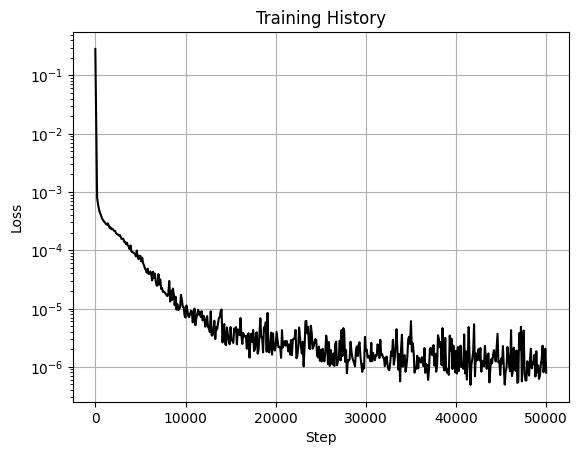

In [7]:
key = jr.key(0)
model_key, loader_key = jr.split(key)

hnn_derivative = HamiltonianNN(key=model_key)
hnn = ODESolver(hnn_derivative)

hnn, hist = klax.fit(
    hnn,
    (ys_flat, ys_t_flat),
    steps=50_000,
    loss_fn=derivative_loss,
    key=loader_key,
)
hist.plot()

Step: 0, Loss: 7.562e+02
Step: 100, Loss: 7.857e+00
Step: 200, Loss: 4.321e-01
Step: 300, Loss: 3.470e-01
Step: 400, Loss: 3.374e-01
Step: 500, Loss: 3.300e-01
Step: 600, Loss: 3.223e-01
Step: 700, Loss: 3.141e-01
Step: 800, Loss: 3.060e-01
Step: 900, Loss: 2.964e-01
Step: 1000, Loss: 2.874e-01
Step: 1100, Loss: 2.784e-01
Step: 1200, Loss: 2.694e-01
Step: 1300, Loss: 2.604e-01
Step: 1400, Loss: 2.513e-01
Step: 1500, Loss: 2.425e-01
Step: 1600, Loss: 2.340e-01
Step: 1700, Loss: 2.251e-01
Step: 1800, Loss: 2.168e-01
Step: 1900, Loss: 2.088e-01
Step: 2000, Loss: 2.010e-01
Step: 2100, Loss: 1.934e-01
Step: 2200, Loss: 1.859e-01
Step: 2300, Loss: 1.785e-01
Step: 2400, Loss: 1.716e-01
Step: 2500, Loss: 1.647e-01
Step: 2600, Loss: 1.585e-01
Step: 2700, Loss: 1.520e-01
Step: 2800, Loss: 1.459e-01
Step: 2900, Loss: 1.403e-01
Step: 3000, Loss: 1.344e-01
Step: 3100, Loss: 1.289e-01
Step: 3200, Loss: 1.239e-01
Step: 3300, Loss: 1.188e-01
Step: 3400, Loss: 1.139e-01
Step: 3500, Loss: 1.092e-01
Step

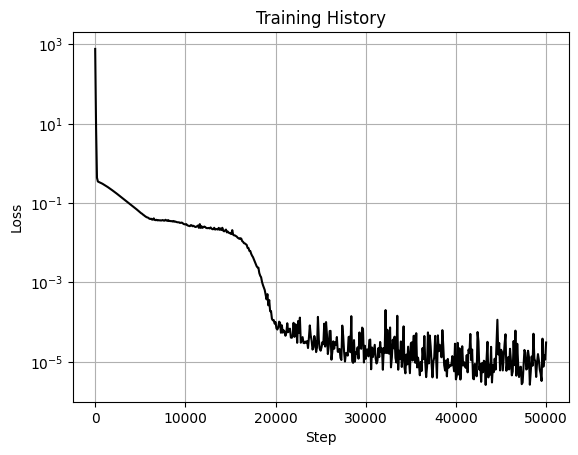

In [8]:
key = jr.key(0)
model_key, loader_key = jr.split(key)

lnn_derivative = LagrangianNN(key=model_key)
lnn = ODESolver(lnn_derivative)

lnn, hist = klax.fit(
    lnn,
    (ys_flat, ys_t_flat),
    steps=50_000,
    loss_fn=derivative_loss,
    optimizer=optax.adam(1e-4),
    key=loader_key,
)

hist.plot()

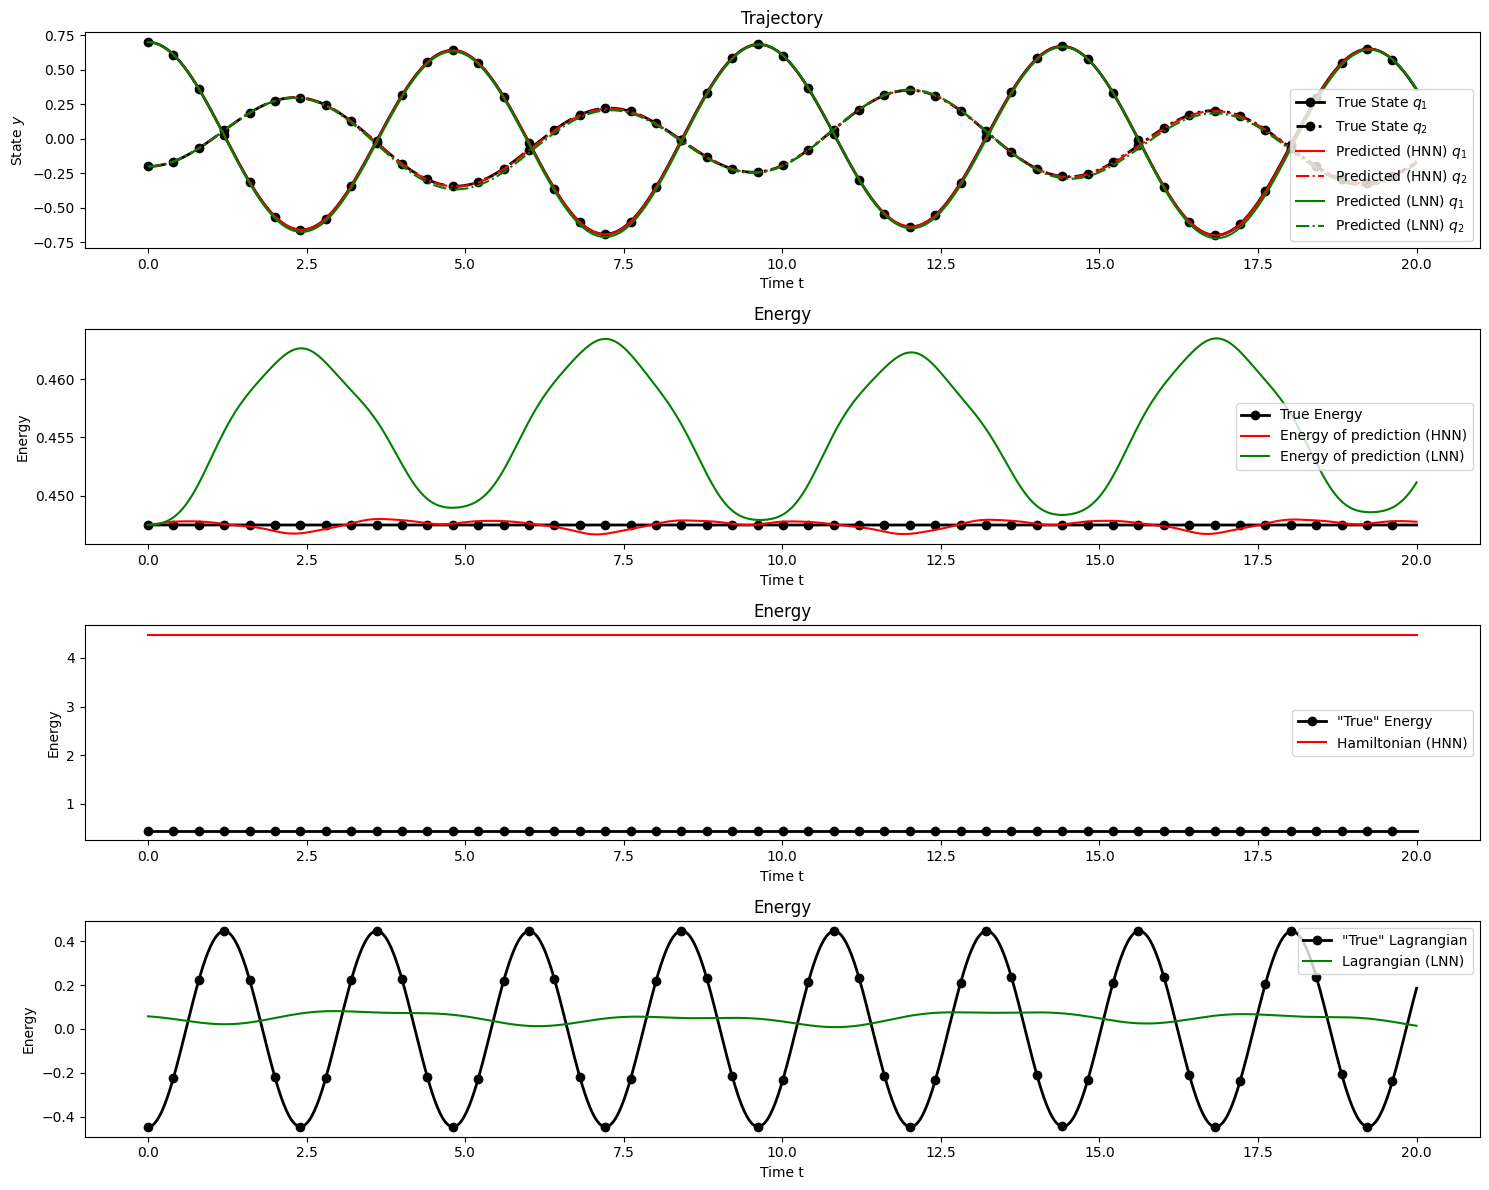

In [9]:
# Plot the NODE prediction(s)
y0_eval = jnp.array([0.7, -0.2, 0.0, 0.0])  # <<< Initial condition for evaluation
t_max_eval = 20                             # <<< Length of evaluation trajectory
states = "positions"                        # <<< Plot only: "positions", "velocities" or "all"
ts_eval = jnp.linspace(0, t_max_eval, 1000)


fig, axes = plt.subplots(4, 1, figsize=(15, 12))
ys_true = true_system(ts_eval, y0_eval)
plot_trajectory(ts_eval, ys_true, ax=axes[0], label="True State", states=states, **true_kwargs)
E_true = jax.vmap(two_mass_oscillator.get_energy)(ys_true)
plot_energy(ts_eval, E_true, ax=axes[1], label="True Energy", **true_kwargs)   # type: ignore
plot_energy(ts_eval, E_true, ax=axes[2], label="\"True\" Energy", **true_kwargs)   # type: ignore
axes[2].set(title="Hamiltonian")
lagranigan_true = jax.vmap(two_mass_oscillator.get_lagrangian)(ys_true)
plot_energy(ts_eval, lagranigan_true, ax=axes[3], label="\"True\" Lagrangian", **true_kwargs)   # type: ignore
try:
    ys_pred_hnn = hnn(ts_eval, y0_eval)
    plot_trajectory(ts_eval, ys_pred_hnn, ax=axes[0], states=states, color="red", label="Predicted (HNN)")
    E_pred_hnn = jax.vmap(two_mass_oscillator.get_energy)(ys_pred_hnn)
    plot_energy(ts_eval, E_pred_hnn, ax=axes[1], color="red", label="Energy of prediction (HNN)")   # type: ignore
    hamiltonian_hnn = jax.vmap(hnn.func.hamiltonian)(ys_pred_hnn)
    plot_energy(ts_eval, hamiltonian_hnn, ax=axes[2], color="red", label="Hamiltonian (HNN)")   # type: ignore
except NameError:
    print("You have not trained the Hamiltonian NN (hnn). Skipping this model.")
try:
    ys_pred_lnn = lnn(ts_eval, y0_eval)
    plot_trajectory(ts_eval, ys_pred_lnn, ax=axes[0], states=states, color="green", label="Predicted (LNN)")
    E_pred_lnn = jax.vmap(two_mass_oscillator.get_energy)(ys_pred_lnn)
    plot_energy(ts_eval, E_pred_lnn, ax=axes[1], color="green", label="Energy of prediction (LNN)")   # type: ignore
    lagrangian_lnn = 20*jax.vmap(lnn.func.lagrangian)(ys_pred_lnn)
    plot_energy(ts_eval, lagrangian_lnn, ax=axes[3], color="green", label="Lagrangian (LNN)")   # type: ignore
except NameError:
    print("You have not trained the Lagrangian NN (lnn). Skipping this model.")
plt.tight_layout()
plt.show()